<a href="https://colab.research.google.com/github/bamtak/ammi-nlp/blob/master/masked_lms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Masked Language Modeling

In this lab, we will overview the **masked language modeling** objective, and how the **Transformer** architecture is used for large-scale masked language modeling.


In [5]:
!wget "https://nyu.box.com/shared/static/axapd6s8x7pzw4kzgq3t2xzqqx35ldy4.zip" -O "mask_lm_lab.zip"
!unzip "./mask_lm_lab.zip" -d "./"
!cp -a "./mask_lm_lab/." "./"
!rm -rf "./mask_lm_lab"
!rm "mask_lm_lab.zip"

--2020-03-18 16:39:47--  https://nyu.box.com/shared/static/axapd6s8x7pzw4kzgq3t2xzqqx35ldy4.zip
Resolving nyu.box.com (nyu.box.com)... 107.152.29.197
Connecting to nyu.box.com (nyu.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/axapd6s8x7pzw4kzgq3t2xzqqx35ldy4.zip [following]
--2020-03-18 16:39:47--  https://nyu.box.com/public/static/axapd6s8x7pzw4kzgq3t2xzqqx35ldy4.zip
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/axapd6s8x7pzw4kzgq3t2xzqqx35ldy4.zip [following]
--2020-03-18 16:39:47--  https://nyu.app.box.com/public/static/axapd6s8x7pzw4kzgq3t2xzqqx35ldy4.zip
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.29.199
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.29.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b

In [64]:
%pylab inline
import os, sys, glob, json, math
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from collections import defaultdict
import torch
import torch.nn as nn
from IPython.display import Image

%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['interactive', 'show']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Background

Recently, Devlin et al. published [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf).


**B**idirectional

**E**ncoder

**R**epresentations from

**T**ransformers


#### Goal: 
1. **pre-train** a model that produces language representations. 
2. **fine-tune** the model on a task.
    


## Masked Language Model Objective

Randomly mask some of the tokens from the input, predict original vocabulary id of each masked token.

- Given sequence $x_1,\ldots,x_N$.

- Form **mask** $m_1,\ldots,m_N$ where $m_i\in \{0,1\}$.
    - E.g. $m_i=1$ with probability 0.15
    
- Form **masked sequence** $\tilde{x}_1,\ldots,\tilde{x}_N$.
    - $\tilde{x}_i=\begin{cases} x_i & m_i=0\\ \texttt{[MASK]} & m_i=1\end{cases}$


#### $$\mathcal{L}_{\text{MLM}}=-\sum_{\underbrace{i | m_i=1}_{\text{MASKED POSITIONS}}}\log p_{\theta}(\underbrace{x_i}_{\text{TRUE TOKEN}}|\underbrace{\tilde{x}_1,\ldots,\tilde{x}_N}_{\text{MASKED SEQUENCE}})$$


<!-- Below, we will discuss the exact form of $\tilde{x}_i$ that the BERT authors used. -->


<!-- #### Diagram of BERT Implementation -->
<!-- ![](bert_overview.png) -->

## Transformers

So far we have modeled a sequence by factorizing the joint distribution into conditionals, and **parameterizing each conditional with a recurrent network**:


#### $$p_{\theta}(x_1,\ldots,x_T)=\prod_{t=1}^T p_{\theta}(x_t | x_{<t})$$
\begin{align}
h_t &= RNN(x_{t-1}, h_t)\\
p_{\theta}(x_t | x_{<t}) &=\text{softmax}\left(Wh_t+b\right),
\end{align}

where $\theta$ are the model parameters (RNN parameters, $W, b$, embedding matrix).


#### Alternative

An alternative proposed in [[Vaswani et al 2017](https://arxiv.org/pdf/1706.03762.pdf)] is to parameterize each conditional with a **particular feed-forward architecture** called the **Transformer**. With this model, it is possible to compute all conditionals with a **single feed-forward pass**:
\begin{align}
(h_1,\ldots,h_T) &= Transformer(x)\\
p_{\theta}(x_t | x_{<t}) &= \text{softmax}\left(Wh_t + b\right)
\end{align}

We will discuss briefly the key ideas, the overall Transformer architecture (encoder only), and how they are used in Pytorch.

### High-Level View

We can view the Transformer encoder as mapping a sequence to a sequence of vectors.

<img src="img/high1.png" alt="Drawing" style="width: 35%;"/>

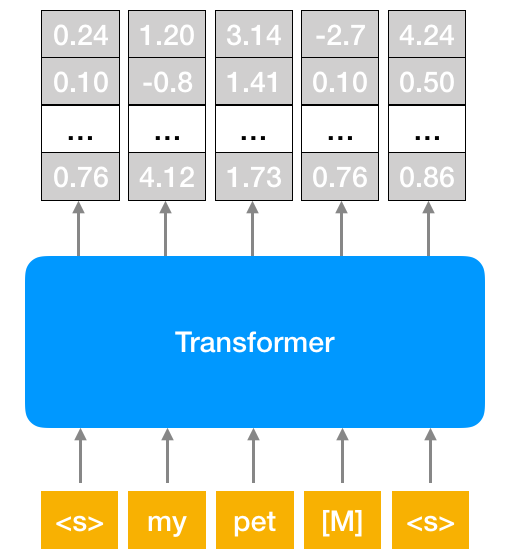

In [65]:
Image("img/high1.png")

Let's step through the key ideas of how this mapping is designed, and discuss some of its resulting properties.

### Key Idea 1: Position Embeddings

Unlike RNNs which can learn positional information via the hidden state over time, the Transformer has no notion of time.

Thus we encode inputs with **position** as well as **token** embeddings:

<img src="/img/high2.png" alt="Drawing" style="width: 35%;"/>

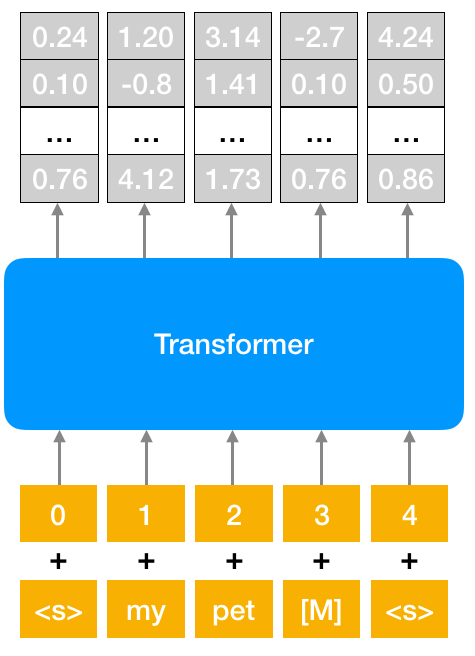

In [67]:
Image("img/high2.png")

In [0]:
input_sequence = ['<s>', 'my', 'pet', '[M]', '<s>']

max_len = 10

vocab = {'<s>': 0, 'my': 1, 'pet': 2, 'dog': 3, 'cat': 4, 'lion': 5, '[M]': 6}

dim = 6

token_embed = nn.Embedding(len(vocab), embedding_dim=dim)
position_embed = nn.Embedding(max_len, embedding_dim=dim)

In [11]:
input_vector = torch.tensor([vocab[x] for x in input_sequence]).unsqueeze(1)

input_embeddings = token_embed(input_vector) + position_embed(torch.arange(len(input_vector)))
input_embeddings.size()

torch.Size([5, 5, 6])

**Warning!!** The pytorch Transformer classes accept input as `Length x Batch x Dim`

#### Key Idea 2: Modularity
The Transformer (encoder) is composed of a stack of **N identical layers**.

<img src="img/layers.png" alt="Drawing" style="width: 35%;"/>

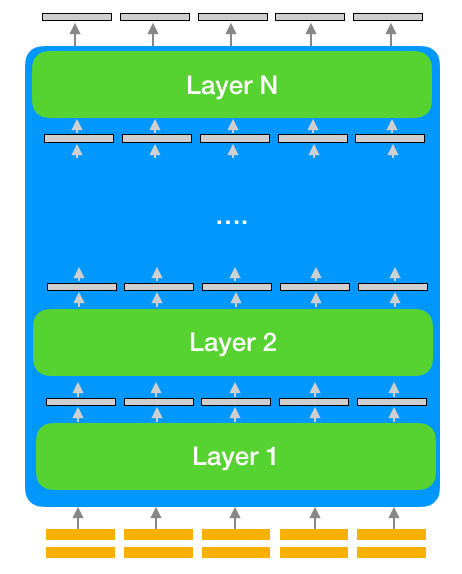

In [68]:
Image("img/layers.png")

In [0]:
import torch.nn as nn
nn.TransformerEncoder?

#### The `forward` passes the input through the N layers, then normalizes it:

**Warning!!** The forward function accepts input as `Length x Batch x Dim`

In [0]:
# nn.TransformerEncoder.forward??

In [0]:
encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=2, dim_feedforward=64, dropout=0.1)

encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

In [15]:
outputs = encoder(input_embeddings)

print("input size: \t%s" % str(tuple(input_embeddings.shape)))
print("output size:\t%s" % str(tuple(outputs.shape)))
outputs

input size: 	(5, 5, 6)
output size:	(5, 5, 6)


tensor([[[-0.3119, -0.1663,  0.5734,  1.4156,  0.3403, -1.8511],
         [ 1.4180,  0.7557, -1.1261, -0.5396,  0.6761, -1.1840],
         [-0.3921,  0.2300,  0.8808, -0.5381,  1.4446, -1.6252],
         [-0.9952, -0.5162,  1.0020, -0.7071,  1.7261, -0.5096],
         [ 0.5920,  0.3546, -0.4663,  1.2125,  0.2499, -1.9426]],

        [[-0.3313, -0.6227,  0.5338,  1.8202, -0.0203, -1.3798],
         [ 1.4673, -0.0097, -0.7136, -0.3712,  1.0647, -1.4375],
         [-1.5142, -0.1103,  0.6228,  0.3107,  1.5645, -0.8735],
         [-1.5983, -0.8959,  0.2154,  0.2171,  1.4912,  0.5705],
         [-0.6355, -0.4592,  0.3355,  1.7309,  0.4641, -1.4357]],

        [[ 0.4115, -0.1010, -0.6748,  1.9035, -0.2417, -1.2974],
         [ 1.5888,  0.3171, -1.2594, -0.4769,  0.7947, -0.9643],
         [ 0.7270,  0.2961, -0.9664,  0.8440,  0.8404, -1.7411],
         [ 0.2897, -0.7545,  1.1356, -0.3920,  1.2506, -1.5295],
         [ 0.6238, -0.0915, -0.8111,  1.8132, -0.2774, -1.2570]],

        [[-0.4758, 

#### Each layer has two parts, **self-attention** and a feed-forward transformation:

<img src="./img/layer.png" alt="Drawing" style="width: 65%;"/>

In [0]:
# nn.TransformerEncoderLayer??

In [0]:
# nn.TransformerEncoderLayer.forward??

### Key Idea 3: Self-Attention

In the RNN, the hidden state contains information about previous tokens.
The Transformer instead performs **attention** over all inputs at a given layer. 'Attention' computes an output vector by taking a weighted sum of input vectors. The weights are 'attention weights'. The Transformer uses **scaled dot-product attention**:
#### $$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

and 'Multi-head Attention' refers to applying several of these operations in parallel.

#### *Key Property*: Each output vector of a layer $n$ can using information from **all** inputs to the layer $n$.

Thus each **final output vector** can incorporate information from **all input words**.

(If we want to prevent information flow such as in left-to-right language modeling, we can use masking).

In [18]:
attn = nn.MultiheadAttention(dim, 2, dropout=0.0)

attn_outputs, attn_weights = attn.forward(query=outputs, key=outputs, value=outputs)

print("input shape: %s" % (str(tuple(outputs.size()))))
print("output shape: %s" % (str(tuple(attn_outputs.size()))))
print(outputs)

print("\nattn weights shape: %s" % (str(tuple(attn_weights.size()))))
print(attn_weights)

input shape: (5, 5, 6)
output shape: (5, 5, 6)
tensor([[[-0.3119, -0.1663,  0.5734,  1.4156,  0.3403, -1.8511],
         [ 1.4180,  0.7557, -1.1261, -0.5396,  0.6761, -1.1840],
         [-0.3921,  0.2300,  0.8808, -0.5381,  1.4446, -1.6252],
         [-0.9952, -0.5162,  1.0020, -0.7071,  1.7261, -0.5096],
         [ 0.5920,  0.3546, -0.4663,  1.2125,  0.2499, -1.9426]],

        [[-0.3313, -0.6227,  0.5338,  1.8202, -0.0203, -1.3798],
         [ 1.4673, -0.0097, -0.7136, -0.3712,  1.0647, -1.4375],
         [-1.5142, -0.1103,  0.6228,  0.3107,  1.5645, -0.8735],
         [-1.5983, -0.8959,  0.2154,  0.2171,  1.4912,  0.5705],
         [-0.6355, -0.4592,  0.3355,  1.7309,  0.4641, -1.4357]],

        [[ 0.4115, -0.1010, -0.6748,  1.9035, -0.2417, -1.2974],
         [ 1.5888,  0.3171, -1.2594, -0.4769,  0.7947, -0.9643],
         [ 0.7270,  0.2961, -0.9664,  0.8440,  0.8404, -1.7411],
         [ 0.2897, -0.7545,  1.1356, -0.3920,  1.2506, -1.5295],
         [ 0.6238, -0.0915, -0.8111,  1

#### Summary

In [0]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, dim=8, num_layers=4, nhead=2):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, dim)
        self.position_embed = nn.Embedding(max_len, dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead, dim_feedforward=64, dropout=0.0)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.projection = nn.Linear(dim, vocab_size)
    
    def features(self, token_indices):
        pos = torch.arange(len(token_indices), device=token_indices.device).unsqueeze(1)
        x = self.token_embed(token_indices) + self.position_embed(pos)
        x = self.encoder(x)
        return x
    
    def forward(self, token_indices):
        x = self.features(token_indices)
        x = self.projection(x)
        return x

In [20]:
input_vector.size()

torch.Size([5, 1])

In [21]:
model = Transformer(len(vocab), max_len=100)

model.features(input_vector)

tensor([[[ 1.2944, -1.0542,  0.9190,  0.8104,  0.1922, -1.3439,  0.4669,
          -1.2848]],

        [[ 0.0662,  0.9383,  0.7310, -2.1762,  0.3383, -0.9772,  0.8502,
           0.2296]],

        [[ 1.1789,  0.7301, -1.9893,  0.3174, -0.8781,  0.0353,  1.0320,
          -0.4264]],

        [[-0.4475,  0.7608, -1.0874, -0.3018, -1.5479,  0.3193,  0.5221,
           1.7824]],

        [[-0.0421,  0.0906, -0.2850,  1.6936, -1.1847, -0.6937,  1.4490,
          -1.0277]]], grad_fn=<NativeLayerNormBackward>)

## Back to Masked Language Modeling

Recall the **key property** of Transformers: due to self-attention, each output vector can incorporate information from *all* input tokens.

<img src="img/mlm.png" alt="Drawing" style="width: 45%;"/>

This is useful for masked language modeling, where we want to use information from the entire context when predicting the masked token(s).

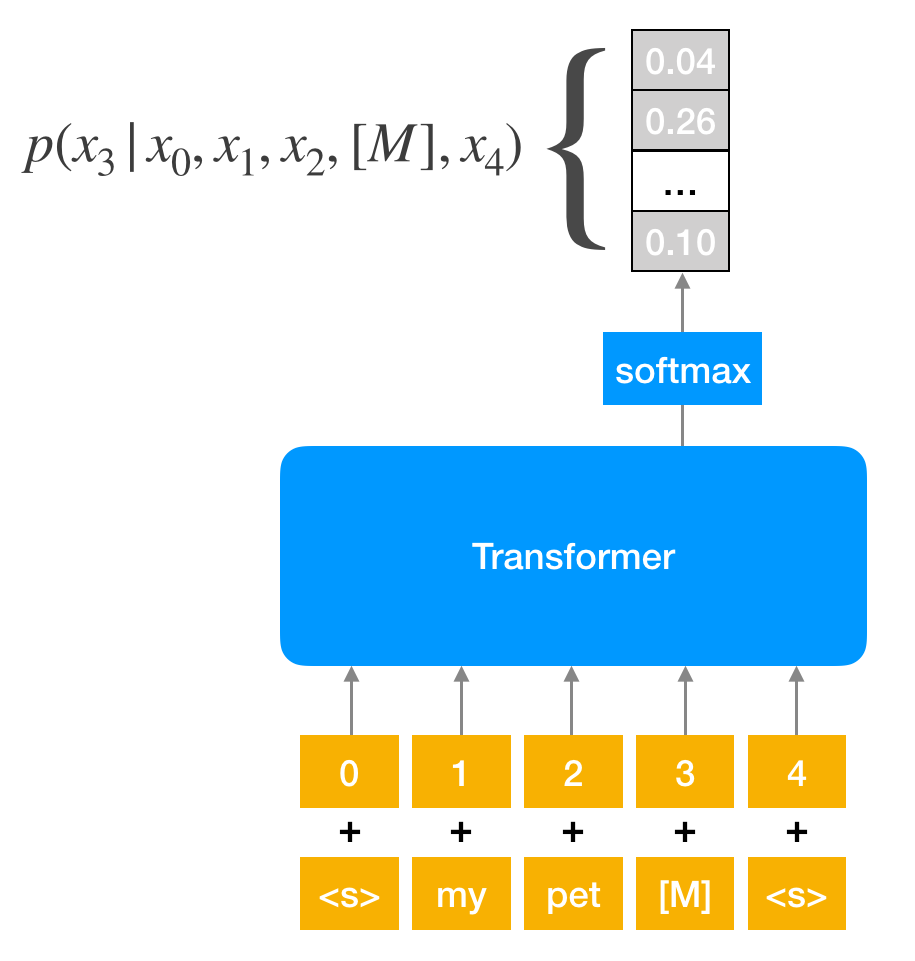

In [69]:
Image("img/mlm.png")

#### MLM on Persona-Chat

In [30]:
!pip install jsonlines

In [31]:
import utils
raw_datasets, datasets, vocab = utils.load_personachat()

100%|██████████| 16181/16181 [00:00<00:00, 226509.91it/s]


Vocab size: 19157


In [0]:
from torch.utils.data.dataloader import DataLoader

trainloader = DataLoader(datasets['train'], batch_size=4, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))
validloader = DataLoader(datasets['valid'], batch_size=4, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))

In [33]:
batch = next(trainloader.__iter__())
batch

tensor([[ 0,  0,  0,  0],
        [ 4,  4,  4, 22],
        [ 5,  5, 18, 23],
        [ 6, 13, 17, 24],
        [ 7, 14, 19, 15],
        [ 8, 15, 13, 25],
        [ 9, 16, 20, 26],
        [10, 17, 21, 27],
        [11, 12, 12, 28],
        [12,  0,  0, 29],
        [ 0,  2,  2, 30],
        [ 2,  2,  2, 24],
        [ 2,  2,  2,  4],
        [ 2,  2,  2, 31],
        [ 2,  2,  2, 32],
        [ 2,  2,  2, 27],
        [ 2,  2,  2, 33],
        [ 2,  2,  2, 34],
        [ 2,  2,  2, 35],
        [ 2,  2,  2, 36],
        [ 2,  2,  2, 24],
        [ 2,  2,  2,  0]])

In [0]:
def mask_tokens(inputs, mask_prob, pad_token_id, mask_token_id, vsize):
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original."""
    inputs = inputs.clone()
    labels = inputs.clone()
    # Sample tokens in each sequence for masked-LM training
    masked_indices = torch.bernoulli(torch.full(labels.shape, mask_prob)).bool()
    masked_indices = masked_indices & (inputs != pad_token_id)
    labels[~masked_indices] = -1  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = mask_token_id

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(vsize, labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [35]:
inputs, labels = mask_tokens(batch, mask_prob=0.15, mask_token_id=vocab.get_id('[M]'), pad_token_id=vocab.get_id('<pad>'), vsize=len(vocab))
print("Mask token id: %d" % vocab.get_id('[M]'))
inputs

Mask token id: 1


tensor([[ 0,  1,  0,  0],
        [ 4,  1,  4, 22],
        [ 5,  1,  1, 23],
        [ 6, 13, 17, 24],
        [ 7, 14, 19, 15],
        [ 8, 15, 13, 25],
        [ 1, 16, 20, 26],
        [ 1, 17, 21, 27],
        [11, 12, 12, 28],
        [12,  0,  0, 29],
        [ 0,  2,  2, 30],
        [ 2,  2,  2, 24],
        [ 2,  2,  2,  1],
        [ 2,  2,  2, 31],
        [ 2,  2,  2, 32],
        [ 2,  2,  2, 27],
        [ 2,  2,  2, 33],
        [ 2,  2,  2, 34],
        [ 2,  2,  2, 35],
        [ 2,  2,  2, 36],
        [ 2,  2,  2, 24],
        [ 2,  2,  2,  0]])

In [36]:
labels

tensor([[-1,  0, -1, -1],
        [-1,  4, -1, -1],
        [-1,  5, 18, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [ 9, -1, -1, -1],
        [10, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1,  4],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1]])

In [0]:
model = Transformer(len(vocab), max_len=200)

In [38]:
logits = model(inputs)
logits.size()

torch.Size([22, 4, 19157])

In [39]:
labels.size()

torch.Size([22, 4])

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [41]:
logits_ = logits.view(-1, logits.size(2))
labels_ = labels.view(-1)

criterion(logits_, labels_)

tensor(9.9377, grad_fn=<NllLossBackward>)

In [0]:
if False:
    import torch.optim as optim
    from tqdm import tqdm, trange
    from collections import defaultdict
    from torch.utils.data.dataloader import DataLoader

    trainloader = DataLoader(datasets['train'], batch_size=64, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))
    validloader = DataLoader(datasets['valid'], batch_size=64, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    model = Transformer(len(vocab), max_len=65, dim=256, nhead=8).to(device)

    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=0.001)

    criterion = nn.CrossEntropyLoss(ignore_index=-1).to(device)

    stats = defaultdict(list)

    for epoch in range(50):
        for step, batch in enumerate(trainloader):
            model.train()        
            # Mask the batch
            inputs, labels = mask_tokens(batch, mask_prob=0.15, 
                                         pad_token_id=vocab.get_id('<pad>'),
                                         mask_token_id=vocab.get_id('[M]'), 
                                         vsize=len(vocab))
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            logits_ = logits.view(-1, logits.size(2))
            labels_ = labels.view(-1)

            optimizer.zero_grad()
            loss = criterion(logits_, labels_)

            loss.backward()
            optimizer.step()

            stats['train_loss'].append(loss.item())
            stats['train_loss_log'].append(loss.item())
            if (step % 500) == 0:
                avg_loss = sum(stats['train_loss_log']) / len(stats['train_loss_log'])
                print("Epoch %d Step %d\tTrain Loss %.3f" % (epoch, step, avg_loss))
                stats['train_loss_log'] = []

        for batch in validloader:
            model.eval()
            with torch.no_grad():
                # Mask the batch
                inputs, labels = mask_tokens(batch, mask_prob=0.15, 
                                             pad_token_id=vocab.get_id('<pad>'),
                                             mask_token_id=vocab.get_id('[M]'), 
                                             vsize=len(vocab))
                inputs = inputs.to(device)
                labels = labels.to(device)

                logits = model(inputs)
                logits_ = logits.view(-1, logits.size(2))
                labels_ = labels.view(-1)

                loss = criterion(logits_, labels_)
                stats['valid_loss'].append(loss.item())
        print("=== Epoch %d\tValid Loss %.3f" % (epoch, stats['valid_loss'][-1]))

### Example Conditionals

#### Load model  

In [43]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

checkpoint = utils.load('model', 'model', best=True)
options = checkpoint['options']
stats = checkpoint['stats']


model = utils.Transformer(len(vocab), options['max_len'], 
                          dim=options['dim'], 
                          nhead=options['nhead'])
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

In [0]:
model.eval()
model = model.to(device)

In [0]:
sentences = [['<s>', 'i', 'have', 'a', 'pet', '[M]', '.', '<s>'],
             ['<s>', 'i', 'have', 'two', 'pet', '[M]', '.', '<s>'],
             ['<s>', 'my', '[M]', 'is', 'a', 'lawyer', '.', '<s>'],
             ['<s>', 'my', '[M]', 'is', 'a', '[M]', '.', '<s>'],
             ['<s>', 'i', '[M]', '[M]', '[M]', 'sometimes', '.' , '<s>']]


def get_top_masked_tokens(tokens, vocab, device, top=10):
    ids = torch.tensor([vocab.get_id(x) for x in tokens], device=device).unsqueeze(1)
    masked = ids == vocab.get_id('[M]')

    logits = model(ids)[masked]
    probs = torch.softmax(logits, -1)

    print(' '.join(tokens))
    for ps in probs:
        probs, idxs = ps.sort(descending=True)

        for i in range(top):
            print("\t%s (%.4f)" % (vocab.get_token(idxs[i].item()),
                                   probs[i].item()))
        print()

In [46]:
for s in sentences:
    get_top_masked_tokens(s, vocab, device)

<s> i have a pet [M] . <s>
	cat (0.0707)
	dog (0.0533)
	sibling (0.0342)
	puppy (0.0340)
	sister (0.0302)
	retriever (0.0265)
	daughter (0.0264)
	shepard (0.0232)
	named (0.0213)
	brother (0.0208)

<s> i have two pet [M] . <s>
	cats (0.1525)
	dogs (0.0874)
	girls (0.0748)
	boys (0.0501)
	brothers (0.0499)
	wives (0.0420)
	children (0.0386)
	kids (0.0377)
	sisters (0.0333)
	, (0.0219)

<s> my [M] is a lawyer . <s>
	mother (0.2872)
	dad (0.2481)
	mom (0.1561)
	husband (0.0864)
	father (0.0363)
	brother (0.0230)
	job (0.0144)
	sister (0.0143)
	parents (0.0131)
	wife (0.0104)

<s> my [M] is a [M] . <s>
	mother (0.2330)
	dad (0.2212)
	mom (0.1373)
	husband (0.1110)
	brother (0.0364)
	father (0.0357)
	sister (0.0285)
	job (0.0145)
	wife (0.0141)
	parents (0.0127)

	teacher (0.0899)
	lawyer (0.0456)
	nurse (0.0426)
	cop (0.0414)
	mechanic (0.0386)
	doctor (0.0259)
	pilot (0.0195)
	journalist (0.0163)
	dancer (0.0148)
	hairdresser (0.0123)

<s> i [M] [M] [M] sometimes . <s>
	am (0.1669)
	love 

## Back to *BERT*

**B**idirectional

**E**ncoder

**R**epresentations from

**T**ransformers

#### - Masked Language Modeling at scale

#### - Learned representations are useful downstream

<img src="img/bert_citations.png" alt="Drawing" style="width: 45%;"/>

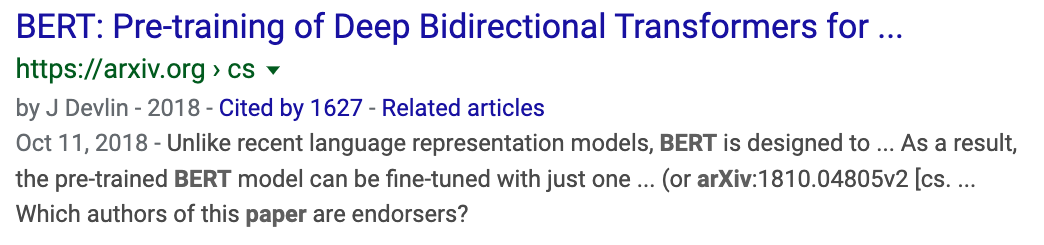

In [70]:
Image("img/bert_citations.png")

#### Great implementation in [transformers](https://github.com/huggingface/transformers):

In [47]:
!pip install transformers

     |████████████████████████████████| 501kB 826kB/s 
     |████████████████████████████████| 3.7MB 7.2MB/s 
     |████████████████████████████████| 870kB 48.1MB/s 
     |████████████████████████████████| 1.0MB 45.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=b02aa258b16422b771ff8700ba15d2069976662aba0988b9f8e25f9e1020c401
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [48]:
import torch
from transformers import (
    BertForMaskedLM,
    BertTokenizer
)

### Details -- Model Variants

- $\text{BERT}_{\text{BASE}}$: 12 layers, hidden dimension 768, 12 attention heads (**110 million parameters**)
- $\text{BERT}_{\text{LARGE}}$: 24 layers, hidden dimension 1024, 16 attention heads (**340 million parameters**)

In [49]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
model = BertForMaskedLM.from_pretrained('bert-base-cased', output_attentions=True)

if torch.cuda.is_available():
    model.cuda()

### Details -- Input Implementation


- `[CLS]` token: starts each sequence. Used as aggregate sequence representation.
- `[SEP]` token: separates two segments (e.g. two sentences).
- **Segment embedding**: learned embedding for every token indicating whether it belongs
to sentence A or sentence B.
- **Position embedding**: learned.


<img src="img/bert_inputs.png" alt="Drawing" style="width: 75%;"/>

**Exercise:** Which downstream tasks would two sequences be useful for?

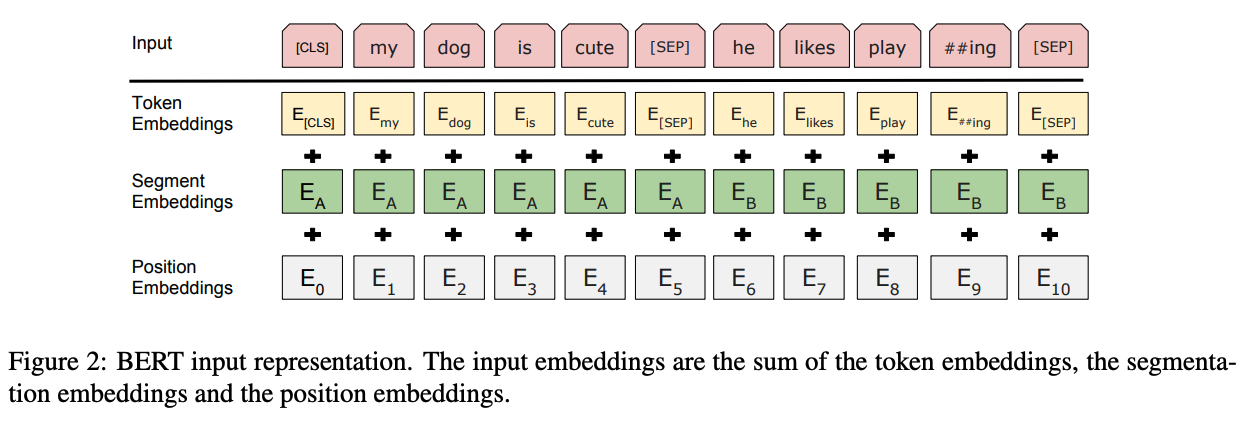

In [71]:
Image("img/bert_inputs.png")

### Tokenization

#### BERT represents text using **subword** tokens with a 30k token vocabulary.  



(more info [here](https://github.com/google/sentencepiece) and in the papers mentioned there)

<!-- - **Token embedding**: WordPiece embeddings with 30k token vocabulary. -->

In [50]:
tokenizer.tokenize("Pretraining is cool.")

['Pre', '##tra', '##ining', 'is', 'cool', '.']

In [51]:
tokenizer.tokenize("BERT represents text using subwords.")

['B', '##ER', '##T', 'represents', 'text', 'using', 'sub', '##words', '.']

### Examining Learned Conditionals (& Representations)

**Probing tasks** can be used to examine aspects of what the model has learned. 

Following [Petroni et al 2019](https://arxiv.org/pdf/1909.01066.pdf) we probe for '**knowledge**' that the model has learned by querying for masked out objects, e.g.:

<img src="img/bert_kb.png" alt="Drawing" style="width: 75%;"/>

The task also illustrates some aspects of the **conditional distributions** and **contextualized representations** that the model has learned.

(image from [Petroni et al 2019])


**Exercise:** The authors only consider *single-token* prediction. Why?

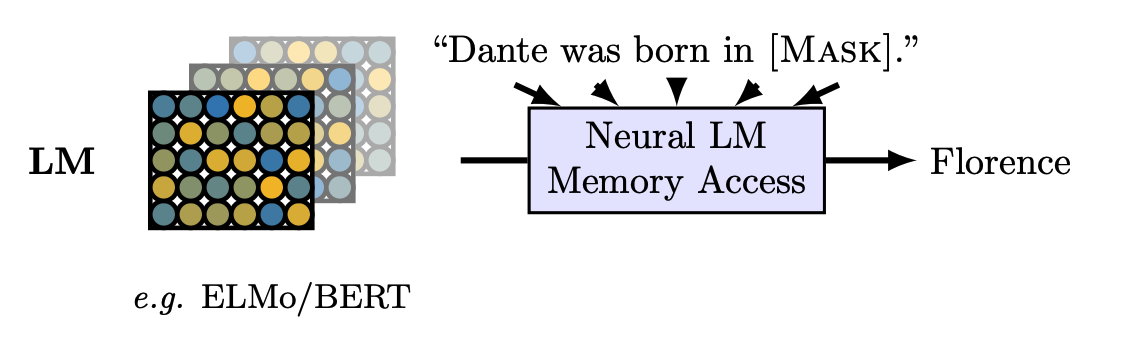

In [63]:
Image('img/bert_kb.png')

#### Probing Task

We use a dataset from [Petroni et al 2019](https://github.com/facebookresearch/LAMA).

In [52]:
import utils
data = utils.load_lama_squad(download=True)
data[0]

{'id': '56be4db0acb8001400a502f0_0',
 'masked_sentences': ['To emphasize the 50th anniversary of the Super Bowl the [MASK] color was used.'],
 'obj_label': 'gold',
 'sub_label': 'Squad'}

In [53]:
results = []

model.eval()
for example in tqdm(data, total=len(data)):
    sentence, label = example['masked_sentences'][0], example['obj_label']
    inp = torch.tensor([
        [tokenizer.cls_token_id] + 
        tokenizer.encode(sentence) + 
        [tokenizer.sep_token_id]
    ], device=device)
    
    mask = (inp == tokenizer.vocab[tokenizer.mask_token])
    out, attn = model(inp)
    
    probs, token_ids = out[mask].softmax(1).topk(10)
    probs = probs[0].tolist()
    token_ids = token_ids[0].tolist()

    tokens = [tokenizer.ids_to_tokens[i] for i in token_ids]

    results.append({
        'sentence': sentence,
        'label': label,
        'top_tokens': tokens,
        'top_probs': probs,
        'correct@1': tokens[0] == label,
        'attn': attn
    })

print("correct@1: %.3f" % (
    len([r for r in results if r['correct@1']]) / len(results)
))

100%|██████████| 305/305 [00:44<00:00,  7.04it/s]

correct@1: 0.121


In [54]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

correct = [r for r in results if r['correct@1']]
wrong = [r for r in results if not r['correct@1']]

def show(idx=0, attn_layer=0, is_correct=True):
    result = correct[idx] if is_correct else wrong[idx]

    # --- format the result into a string
    top_str = '\n\t'.join([
        ('\t%s\t(%.4f)' % (tokens, probs)) 
        for tokens, probs in zip(result['top_tokens'], result['top_probs'])
    ])
    print("%s\n\tlabel:\t%s\n\n\ttop:%s" % (
        result['sentence'], 
        result['label'], 
        top_str
    ))

    # --- visualize attention
    print("Attention weights (12 heads) from layer %d:" % attn_layer)
    fig, axs = plt.subplots(3, 4, figsize=(18, 12))

    toks = ['[CLS]'] + tokenizer.tokenize(result['sentence']) + ['[SEP]']
    for i, ax in enumerate(axs.reshape(-1)):
        ax.matshow(result['attn'][attn_layer][0][i].data.cpu().numpy(), cmap='gray')

        ax.set_xticks(range(len(toks)))
        ax.set_xticklabels(toks, rotation=90, fontsize=15)
        ax.set_yticks(range(len(toks)))
        ax.set_yticklabels(toks, fontsize=15)
    plt.tight_layout()
    
interactive(
    show, 
    idx=(0, min(len(correct), len(wrong))-1), 
    attn_layer=range(12), 
    is_correct=True
)

interactive(children=(IntSlider(value=0, description='idx', max=36), Dropdown(description='attn_layer', option…